In [1]:
import cv2                      # working with, mainly resizing, images
import numpy as np              # dealing with arrays
import os                       # dealing with directories
from random import shuffle      # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm           # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion   
import tensorflow as tf
import matplotlib.pyplot as plt
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
%matplotlib inline
TRAIN_DIR = 'C:/Users/kwanjai/dog_cat/train/train'
TEST_DIR = 'C:/Users/kwanjai/dog_cat/test/test'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'dogs-vs-cats-convnet'

In [2]:
def create_label(image_name):
    """ Create an one-hot encoded vector from image name """
    word_label = image_name.split('.')[-3]
    if word_label == 'cat':
        return np.array([1,0]) #cat = 0
    elif word_label == 'dog':
        return np.array([0,1]) #dog = 1

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img_data), create_label(img)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img_data), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [4]:
# If dataset is not created:
train_data = create_train_data()
test_data = create_test_data()

# If you have already created the dataset:
# train_data = np.load('train_data.npy')
# test_data = np.load('test_data.npy')

train = train_data[:-500]
test = train_data[-500:]

X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = [i[1] for i in train]

X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = [i[1] for i in test]

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:28<00:00, 141.04it/s]


In [5]:

tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 11.35552 | time: 80.359s
| Adam | epoch: 010 | loss: 11.35552 - acc: 0.5068 -- iter: 24448/24500
Training Step: 3830  | total loss: 11.40724 | time: 81.644s
| Adam | epoch: 010 | loss: 11.40724 - acc: 0.5046 | val_loss: 11.88134 - val_acc: 0.4840 -- iter: 24500/24500
--


In [6]:
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
result = model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)
print(result)

Training Step: 3829  | total loss: 0.33034 | time: 87.795s
| Adam | epoch: 010 | loss: 0.33034 - acc: 0.8589 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.33486 | time: 89.006s
| Adam | epoch: 010 | loss: 0.33486 - acc: 0.8558 | val_loss: 0.51011 - val_acc: 0.7440 -- iter: 24500/24500
--
None


cat: 0.42986157536506653, dog: 0.5701384544372559


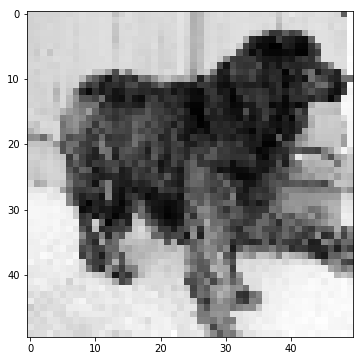

In [7]:
d = test_data[0]
img_data, img_num = d

data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
prediction = model.predict([data])[0]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap="gray")

print('cat: {}, dog: {}'.format(prediction[0],prediction[1]))

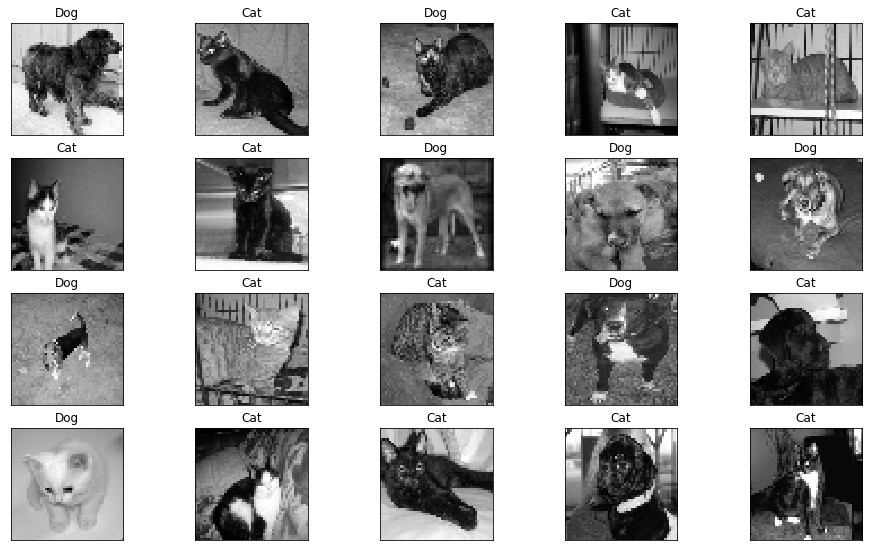

In [8]:
fig=plt.figure(figsize=(16, 12))

for num, data in enumerate(test_data[:20]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(5, 5, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [9]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:28<00:00, 433.47it/s]
